In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from hyperopt import STATUS_OK, Trials, hp, space_eval, tpe, fmin
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

rcParams['figure.figsize'] = (24, 16)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

<h2>EDA
<h5>학습데이터 로드

In [43]:
#경로 설정
data_dir = Path('../dacon_code/')
feature_dir = Path('../build/feature')
val_dir = Path('../dacon_code/build/val')
tst_dir = Path('../dacon_code/build/tst')
sub_dir = Path('../dacon_code/build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
feature2_file = data_dir / 'feature2.csv'
sample_file = data_dir / 'sample_submission.csv'

seed = 42

In [3]:
trn = pd.read_csv(trn_file, index_col=0)
print(trn.shape)
trn.head()

(320000, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,18,18,1.1898,1.1907,1.1890,1.1894,1.1902,0
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,1,1,1.2533,1.2578,1.2488,1.2510,1.2555,1
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,2,2,1.0225,1.0241,1.0210,1.0217,1.0233,0
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,4,3,1.2054,1.2061,1.2049,1.2051,1.2057,0
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,13,12,1.1939,1.1943,1.1937,1.1938,1.1941,0


In [4]:
trn.tail()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
319995,18.3656,17.2409,16.7739,16.4850,16.3404,5.1988e-02,18.1328,17.0406,16.6374,16.3861,16.2874,2,2,1.0930,1.0888,1.0973,1.0951,1.0909,2
319996,18.6856,17.6658,17.1904,16.8169,16.6367,8.7261e-02,18.5207,17.5131,17.0871,16.7436,16.6017,2,2,1.0517,1.0508,1.0526,1.0522,1.0513,1
319997,21.1890,18.4234,17.2956,16.9011,16.6841,-1.0148e-05,20.9890,18.3076,17.2152,16.8403,16.6355,31,30,1.1933,1.1941,1.1925,1.1929,1.1937,0
319998,18.8472,17.3186,16.5057,16.1806,15.9116,-4.5209e-05,16.3900,15.4058,15.1823,15.1969,15.1793,1,1,1.1725,1.1726,1.1725,1.1725,1.1725,0
319999,19.8604,18.8199,18.5156,18.4149,18.3080,-9.6544e-04,19.8256,18.7819,18.4908,18.3987,18.3098,1,1,1.0571,1.0562,1.0580,1.0575,1.0567,0


<h4>데이터 개요

In [5]:
trn.describe()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
count,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,3.2000e+05,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000,320000.0000
mean,19.8524,18.3768,17.7358,17.1742,16.8752,5.8308e-02,19.6289,18.2271,17.6154,17.1523,16.8693,6.3327,6.1388,1.1758,1.1765,1.1751,1.1754,1.1761,1.1163
std,1.9455,31.1108,1.4662,52.5615,57.1463,5.7546e-01,1.9236,17.7866,1.4730,25.0758,35.4365,8.8811,8.5516,0.1163,0.1181,0.1147,0.1155,0.1172,0.9235
min,-17.6875,-17555.3656,7.7314,-23955.8178,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-16.3802,-9999.0000,-9999.0000,1.0000,1.0000,1.0001,1.0000,1.0002,1.0001,1.0000,0.0000
25%,18.7242,17.4749,16.8772,16.5239,16.2889,3.5580e-05,18.5636,17.3484,16.7871,16.4530,16.2341,1.0000,1.0000,1.0882,1.0884,1.0878,1.0880,1.0883,0.0000
50%,19.4194,18.1405,17.5258,17.1497,16.9176,4.7129e-02,19.2646,18.0224,17.4434,17.0874,16.8694,2.0000,2.0000,1.1793,1.1792,1.1794,1.1794,1.1793,1.0000
75%,20.4321,19.0732,18.4281,18.0074,17.7289,9.4597e-02,20.1976,18.8884,18.2911,17.9070,17.6557,5.0000,5.0000,1.2275,1.2260,1.2292,1.2286,1.2268,2.0000
max,58.6233,46.3383,72.0097,50.1641,52.6127,6.2323e+01,30.7779,30.6132,31.9572,32.0162,30.7813,44.0000,42.0000,2.0508,2.0803,2.0221,2.0363,2.0654,2.0000


In [6]:
trn.dtypes

u            float64
g            float64
r            float64
i            float64
z            float64
redshift     float64
dered_u      float64
dered_g      float64
dered_r      float64
dered_i      float64
dered_z      float64
nObserve       int64
nDetect        int64
airmass_u    float64
airmass_g    float64
airmass_r    float64
airmass_i    float64
airmass_z    float64
class          int64
dtype: object

<h4>종속변수 분포

In [7]:
trn['class'].value_counts().sort_index()

0    119996
1     42785
2    157219
Name: class, dtype: int64

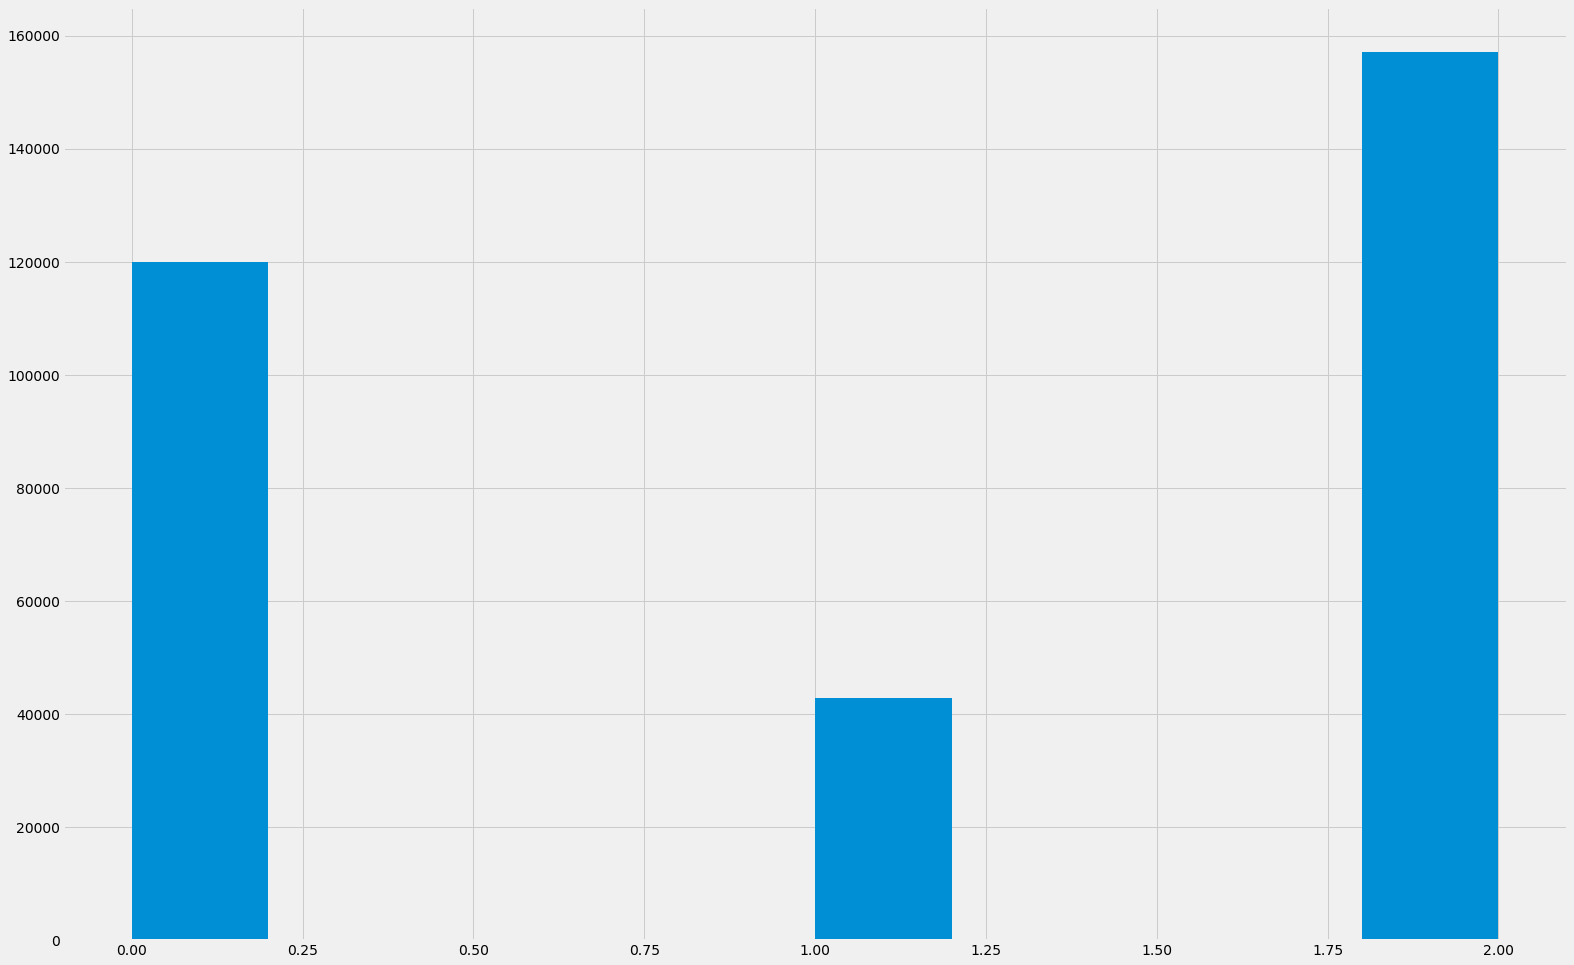

In [8]:
trn['class'].hist()

<h4>독립변수 분포

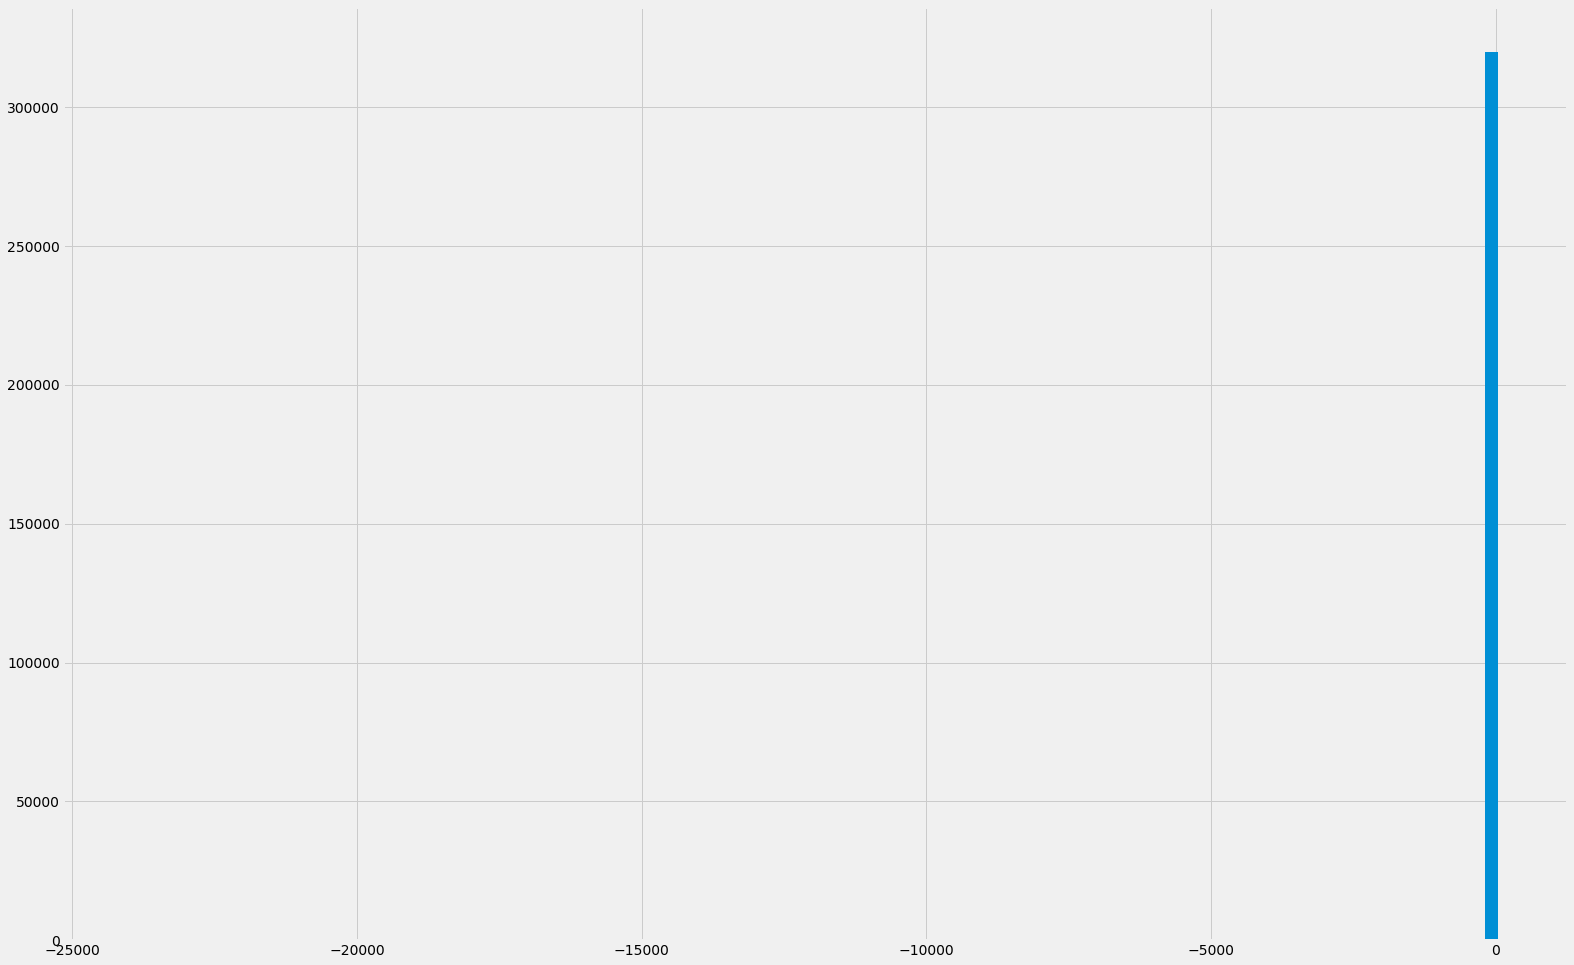

In [9]:
trn['i'].hist(bins=100)

In [10]:
trn.loc[trn['i'] < 0]

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
107428,19.3774,18.2789,17.9404,-23955.8178,-23955.8178,0.0671,19.1142,18.1270,17.8280,-9999.0000,-9999.0000,5,4,1.3060,1.3121,1.3002,1.3031,1.3090,2
134102,18.0590,19.3009,19.0443,-5.4550,13.4289,0.0349,18.0384,19.4843,19.3937,23.6095,24.1169,1,1,1.0693,1.0710,1.0678,1.0685,1.0701,2
173287,19.9833,-17555.3656,17.9093,-17555.3656,-17555.3656,0.0932,19.7719,-9999.0000,17.8146,-9999.0000,-9999.0000,5,4,1.3061,1.3121,1.3002,1.3031,1.3090,1
181371,14.6680,14.0357,13.7587,-23.9024,13.5329,0.0007,14.5893,13.9768,13.7133,24.4559,13.5264,2,2,1.2933,1.2867,1.3000,1.2966,1.2900,1


In [11]:
trn['dered_i'].quantile(np.arange(0, 1, .01))

0.00   -9999.0000
0.01      14.1238
0.02      14.6338
0.03      14.9256
0.04      15.1070
          ...    
0.95      19.6019
0.96      19.7939
0.97      19.9848
0.98      20.1736
0.99      20.5396
Name: dered_i, Length: 100, dtype: float64

In [12]:
trn.loc[trn['dered_i'] < 0]

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
75409,24.0610,23.8879,20.5890,18.1014,16.4314,1.6993e-04,-30.6337,-18.6560,-8.7560,-3.6973,0.2159,11,8,1.1858,1.1859,1.1859,1.1858,1.1858,0
107428,19.3774,18.2789,17.9404,-23955.8178,-23955.8178,6.7144e-02,19.1142,18.1270,17.8280,-9999.0000,-9999.0000,5,4,1.3060,1.3121,1.3002,1.3031,1.3090,2
173287,19.9833,-17555.3656,17.9093,-17555.3656,-17555.3656,9.3168e-02,19.7719,-9999.0000,17.8146,-9999.0000,-9999.0000,5,4,1.3061,1.3121,1.3002,1.3031,1.3090,1
203328,19.1628,17.7936,16.2919,15.1547,14.2541,2.1426e-04,-35.8185,-25.0458,-13.3443,-6.8683,-2.1271,10,9,1.2710,1.2660,1.2762,1.2735,1.2685,0
218728,22.2886,19.7721,17.6775,16.3672,15.1206,1.6016e-04,-41.0768,-29.4654,-16.3802,-8.9412,-3.7059,6,4,1.1851,1.1852,1.1852,1.1851,1.1852,0
294574,22.7283,20.9049,19.4225,17.8771,17.0411,-7.0816e-06,-42.8375,-30.3208,-16.0172,-8.4604,-2.5462,5,3,1.2579,1.2533,1.2627,1.2603,1.2556,0
295627,23.5286,20.9588,19.4514,17.8901,17.0632,-2.0197e-05,-42.8375,-30.3208,-16.0172,-8.4604,-2.5462,5,3,1.2579,1.2533,1.2627,1.2603,1.2556,0


<h3>시험 데이터 로드

In [13]:
tst = pd.read_csv(tst_file, index_col=0)
print(tst.shape)
tst.head()

(80000, 18)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z
id,,,,,,,,,,,,,,,,,,
320000,19.1431,18.0172,17.4733,17.1144,16.9263,1.2130e-01,19.0750,17.9550,17.4308,17.0838,16.9087,1,1,1.1563,1.1515,1.1613,1.1588,1.1539
320001,18.7409,17.1705,16.3691,15.9865,15.7307,-6.6907e-05,15.0703,14.3098,14.3901,14.5160,14.6372,2,2,1.0076,1.0074,1.0080,1.0078,1.0075
320002,19.2980,17.8803,17.2221,16.8096,16.6352,1.1001e-01,19.1004,17.7726,17.1460,16.7497,16.5689,1,1,1.3809,1.3905,1.3715,1.3761,1.3856
320003,18.0775,17.1569,16.9041,16.8118,16.7955,2.9697e-05,17.9729,17.0735,16.8470,16.7700,16.7668,1,1,1.1408,1.1408,1.1409,1.1408,1.1408
320004,17.8325,16.7646,16.2135,15.8722,15.6621,6.8471e-02,17.7545,16.6794,16.1563,15.8315,15.6433,2,2,1.1110,1.1077,1.1145,1.1127,1.1093


<h3>학습/시험 데이터 결합

In [14]:
df = pd.concat([trn, tst], axis=0)
print(df.shape)
df.tail()

(400000, 19)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-0.0003,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,NaN
399996,21.5229,20.7283,20.6087,21.0049,20.8458,0.0655,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,NaN
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-0.0008,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,NaN
399998,18.8997,17.6009,17.1329,16.8223,16.5946,0.0428,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.1804,1.1813,1.1797,1.1800,1.1809,NaN
399999,20.7587,20.4252,20.5362,20.7729,20.9698,0.0003,20.4958,20.2181,20.3939,20.6696,20.9085,5,5,1.1832,1.1775,1.1889,1.1860,1.1803,NaN


In [15]:
df.fillna(-1, inplace=True)
df.tail()

,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class
id,,,,,,,,,,,,,,,,,,,
399995,19.6734,18.6617,18.2708,18.1225,18.0627,-0.0003,19.3361,18.3933,18.0860,17.9861,17.9670,17,17,1.1858,1.1863,1.1855,1.1857,1.1861,-1.0
399996,21.5229,20.7283,20.6087,21.0049,20.8458,0.0655,21.3993,20.6399,20.5451,20.9507,20.7827,8,4,1.2850,1.2908,1.2793,1.2821,1.2878,-1.0
399997,19.3991,18.2411,18.1605,18.1978,18.2018,-0.0008,18.9136,17.8753,17.9047,18.0043,18.0400,1,1,1.1885,1.1886,1.1885,1.1885,1.1885,-1.0
399998,18.8997,17.6009,17.1329,16.8223,16.5946,0.0428,18.7715,17.4880,17.0557,16.7660,16.5585,17,17,1.1804,1.1813,1.1797,1.1800,1.1809,-1.0
399999,20.7587,20.4252,20.5362,20.7729,20.9698,0.0003,20.4958,20.2181,20.3939,20.6696,20.9085,5,5,1.1832,1.1775,1.1889,1.1860,1.1803,-1.0


<h3>피쳐 변환

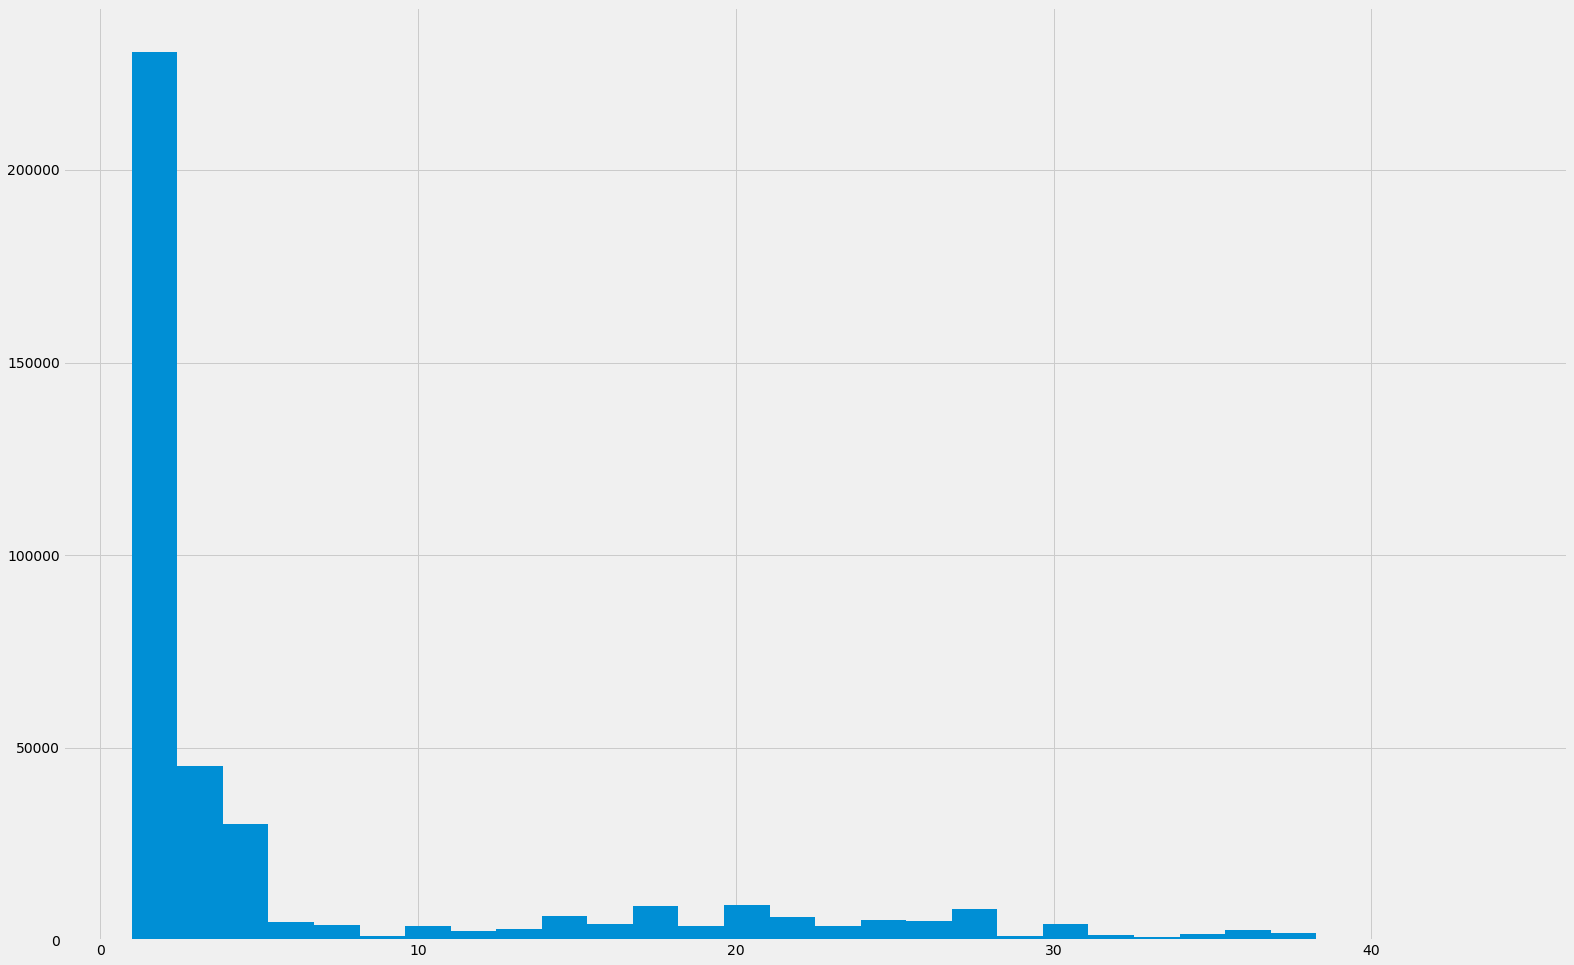

In [16]:
df['nObserve'].hist(bins=30)

In [17]:
df['nObserve'] = df['nObserve'].apply(np.log1p)

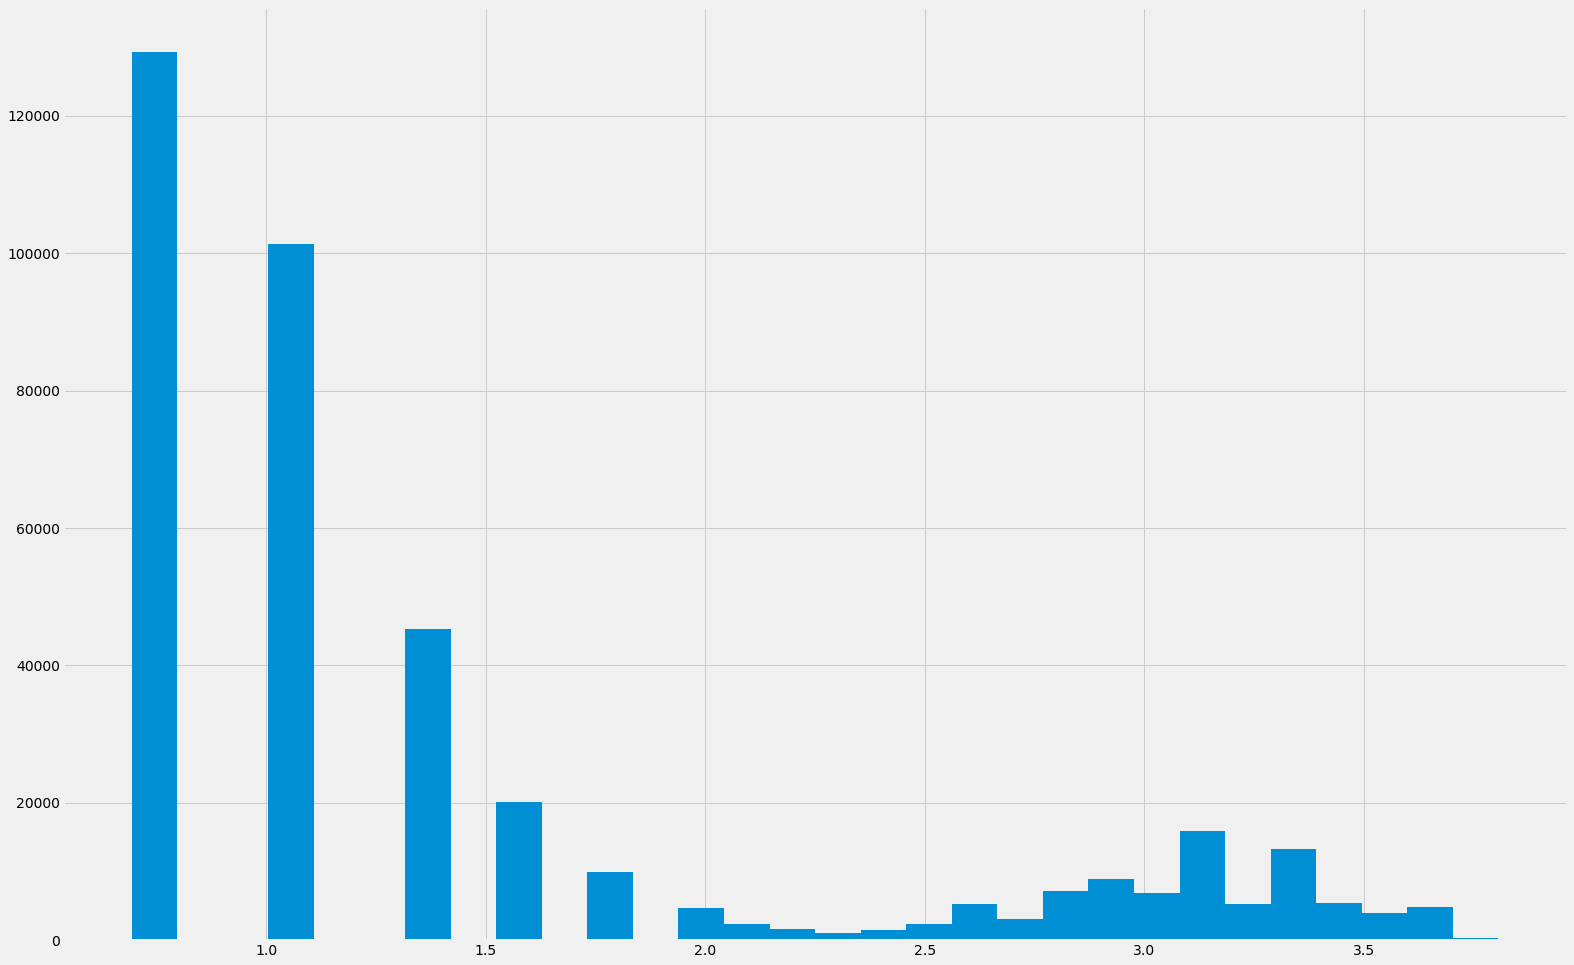

In [18]:
df['nObserve'].hist(bins=30)

### 피쳐 생성

In [19]:
df['d_dered_u'] = df['dered_u'] - df['u']
df['d_dered_g'] = df['dered_g'] - df['g']
df['d_dered_r'] = df['dered_r'] - df['r']
df['d_dered_i'] = df['dered_i'] - df['i']
df['d_dered_z'] = df['dered_z'] - df['z']

df['d_dered_ug'] = df['dered_u'] - df['dered_g']
df['d_dered_ur'] = df['dered_u'] - df['dered_r']
df['d_dered_ui'] = df['dered_u'] - df['dered_i']
df['d_dered_uz'] = df['dered_u'] - df['dered_z']

df['d_dered_gu'] = df['dered_g'] - df['dered_u']
df['d_dered_gr'] = df['dered_g'] - df['dered_r']
df['d_dered_gi'] = df['dered_g'] - df['dered_i']
df['d_dered_gz'] = df['dered_g'] - df['dered_z']

df['d_dered_ru'] = df['dered_r'] - df['dered_u']
df['d_dered_rg'] = df['dered_r'] - df['dered_g']
df['d_dered_ri'] = df['dered_r'] - df['dered_i']
df['d_dered_rz'] = df['dered_r'] - df['dered_z']

df['d_dered_iu'] = df['dered_i'] - df['dered_u']
df['d_dered_ig'] = df['dered_i'] - df['dered_g']
df['d_dered_ir'] = df['dered_i'] - df['dered_r']
df['d_dered_iz'] = df['dered_i'] - df['dered_z']

df['d_dered_zu'] = df['dered_z'] - df['dered_u']
df['d_dered_zg'] = df['dered_z'] - df['dered_g']
df['d_dered_zr'] = df['dered_z'] - df['dered_r']
df['d_dered_zi'] = df['dered_z'] - df['dered_i']

df['d_obs_det'] = df['nObserve'] - df['nDetect']

df['s_red_dered_u'] = df['redshift'] + df['dered_u']
df['s_red_dered_g'] = df['redshift'] + df['dered_g']
df['s_red_dered_r'] = df['redshift'] + df['dered_r']
df['s_red_dered_i'] = df['redshift'] + df['dered_i']
df['s_red_dered_i'] = df['redshift'] + df['dered_z']

df['m_red_dered_u'] = df['redshift'] * df['dered_u']
df['m_red_dered_g'] = df['redshift'] * df['dered_g']
df['m_red_dered_r'] = df['redshift'] * df['dered_r']
df['m_red_dered_i'] = df['redshift'] * df['dered_i']
df['m_red_dered_z'] = df['redshift'] * df['dered_z']

df['v_red_dered_u'] = df['redshift'] / df['dered_u']
df['v_red_dered_g'] = df['redshift'] / df['dered_g']
df['v_red_dered_r'] = df['redshift'] / df['dered_r']
df['v_red_dered_i'] = df['redshift'] / df['dered_i']
df['v_red_dered_z'] = df['redshift'] / df['dered_z']

df['d_red_dered_u'] = df['redshift'] - df['dered_u']
df['d_red_dered_g'] = df['redshift'] - df['dered_g']
df['d_red_dered_r'] = df['redshift'] - df['dered_r']
df['d_red_dered_i'] = df['redshift'] - df['dered_i']
df['d_red_dered_z'] = df['redshift'] - df['dered_z']

df['s_ddir_ddgr'] = df['d_dered_ir'] + df['d_dered_gr']
df['s_ddir_ddiz'] = df['d_dered_ir'] + df['d_dered_iz']
df['s_ddgr_ddgi'] = df['d_dered_gr'] + df['d_dered_gi']
df['s_ddgr_ddgu'] = df['d_dered_gr'] + df['d_dered_gu']
df['s_ddug_ddzi'] = df['d_dered_ug'] + df['d_dered_zi']
df['s_ddir_ddug'] = df['d_dered_ir'] + df['d_dered_ug']
df['s_ddir_ddgu'] = df['d_dered_ir'] + df['d_dered_gu']
#df['s_ddur_ddrg'] = df['d_dered_ur'] + df['d_dered_rg']
#df['s_ddiz_ddri'] = df['d_dered_iz'] + df['d_dered_ri']
#df['s_ddir_ddgr'] = df['d_dered_ir'] + df['d_dered_gr']
#df['s_ddug_ddir'] = df['d_dered_ug'] + df['d_dered_ir']                                    


df['m_red_airmass_u'] = df['redshift'] * df['airmass_u']

print(df.shape)
df.head()

(400000, 72)


,u,g,r,i,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,nDetect,airmass_u,airmass_g,airmass_r,airmass_i,airmass_z,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ug,d_dered_ur,d_dered_ui,d_dered_uz,d_dered_gu,d_dered_gr,d_dered_gi,d_dered_gz,d_dered_ru,d_dered_rg,d_dered_ri,d_dered_rz,d_dered_iu,d_dered_ig,d_dered_ir,d_dered_iz,d_dered_zu,d_dered_zg,d_dered_zr,d_dered_zi,d_obs_det,s_red_dered_u,s_red_dered_g,s_red_dered_r,s_red_dered_i,m_red_dered_u,m_red_dered_g,m_red_dered_r,m_red_dered_i,m_red_dered_z,v_red_dered_u,v_red_dered_g,v_red_dered_r,v_red_dered_i,v_red_dered_z,d_red_dered_u,d_red_dered_g,d_red_dered_r,d_red_dered_i,d_red_dered_z,s_ddir_ddgr,s_ddir_ddiz,s_ddgr_ddgi,s_ddgr_ddgu,s_ddug_ddzi,s_ddir_ddug,s_ddir_ddgu,m_red_airmass_u
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,23.2640,20.3368,19.0095,17.6724,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,18,1.1898,1.1907,1.1890,1.1894,1.1902,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,2.8665,4.1691,5.4921,6.2153,-2.8665,1.3027,2.6257,3.3488,-4.1691,-1.3027,1.3230,2.0462,-5.4921,-2.6257,-1.3230,0.7232,-6.2153,-3.3488,-2.0462,-0.7232,-15.0556,23.1242,20.2577,18.9550,16.9089,-0.0019,-0.0016,-0.0015,-0.0014,-0.0014,-3.5065e-06,-4.0027e-06,-4.2778e-06,-4.5988e-06,-4.7955e-06,-23.1243,-20.2579,-18.9552,-17.6322,-16.9090,-0.0203,-0.5998,3.9283,-1.5638,2.1433,1.5435,-4.1895,-9.6474e-05
1,15.0521,14.0620,13.4524,13.2684,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1,1.2533,1.2578,1.2488,1.2510,1.2555,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,0.9619,1.5550,1.7302,1.8317,-0.9619,0.5931,0.7683,0.8698,-1.5550,-0.5931,0.1751,0.2767,-1.7302,-0.7683,-0.1751,0.1016,-1.8317,-0.8698,-0.2767,-0.1016,-0.3069,14.9709,14.0090,13.4159,13.1392,0.0674,0.0631,0.0604,0.0596,0.0592,3.0108e-04,3.2176e-04,3.3599e-04,3.4043e-04,3.4307e-04,-14.9619,-14.0000,-13.4069,-13.2317,-13.1302,0.4180,-0.0736,1.3614,-0.3688,0.8603,0.7868,-1.1370,5.6472e-03
2,16.7864,15.8254,15.5363,15.3935,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,2,1.0225,1.0241,1.0210,1.0217,1.0233,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,0.9211,1.1676,1.2859,1.3116,-0.9211,0.2466,0.3649,0.3905,-1.1676,-0.2466,0.1183,0.1440,-1.2859,-0.3649,-0.1183,0.0257,-1.3116,-0.3905,-0.1440,-0.0257,-0.9014,16.6081,15.6871,15.4405,15.2966,0.0078,0.0074,0.0073,0.0072,0.0072,2.8419e-05,3.0088e-05,3.0568e-05,3.0804e-05,3.0856e-05,-16.6072,-15.6861,-15.4396,-15.3213,-15.2956,0.1282,-0.0927,0.6114,-0.6745,0.8954,0.8027,-1.0394,4.8260e-04
3,25.6606,21.1887,20.2212,19.8949,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,3,1.2054,1.2061,1.2049,1.2051,1.2057,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,4.3590,5.2664,5.5590,5.7985,-4.3590,0.9074,1.2000,1.4395,-5.2664,-0.9074,0.2926,0.5321,-5.5590,-1.2000,-0.2926,0.2395,-5.7985,-1.4395,-0.5321,-0.2395,-1.3906,25.3537,20.9947,20.0873,19.5552,0.0001,0.0001,0.0001,0.0001,0.0001,2.2933e-07,2.7694e-07,2.8945e-07,2.9373e-07,2.9733e-07,-25.3536,-20.9946,-20.0873,-19.7946,-19.5552,0.6148,-0.0531,2.1074,-3.4516,4.1195,4.0664,-4.6516,7.0085e-06
4,24.4534,20.6992,19.0424,18.3242,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,12,1.1939,1.1943,1.1937,1.1938,1.1941,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,3.3376,4.9084,5.5811,5.8955,-3.3376,1.5709,2.2436,2.5579,-4.9084,-1.5709,0.6727,0.9871,-5.5811,-2.2436,-0.6727,0.3144,-5.8955,-2.5579,-0.9871,-0.3144,-9.3609,23.7714,20.4338,18.8630,17.8759,-0.0008,-0.0007,-0.0006,-0.0006,-0.0006,-1.3986e-06,-1.6271e-06,-1.7626e-06,-1.8277e-06,-1.8599e-06,-23.7714,-20.4339,-18.8630,-18.1903,-17.8760,0.8981,-0.3583,3.8144,-1.7667,3.0232,2.6649,-4.0103,-3.9695e-05


<h3>피쳐 삭제

In [20]:
df.corr().style.background_gradient()

In [21]:
df.drop(['airmass_z', 'airmass_i', 'airmass_r', 'dered_i', 'dered_r', 'u', 'g', 'r', 'i', 'nDetect', 'airmass_g','d_dered_rg', 'd_dered_ri'], 
        axis=1, inplace=True)
print(df.shape)
df.head()

(400000, 59)


,z,redshift,dered_u,dered_g,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ug,d_dered_ur,d_dered_ui,d_dered_uz,d_dered_gu,d_dered_gr,d_dered_gi,d_dered_gz,d_dered_ru,d_dered_rz,d_dered_iu,d_dered_ig,d_dered_ir,d_dered_iz,d_dered_zu,d_dered_zg,d_dered_zr,d_dered_zi,d_obs_det,s_red_dered_u,s_red_dered_g,s_red_dered_r,s_red_dered_i,m_red_dered_u,m_red_dered_g,m_red_dered_r,m_red_dered_i,m_red_dered_z,v_red_dered_u,v_red_dered_g,v_red_dered_r,v_red_dered_i,v_red_dered_z,d_red_dered_u,d_red_dered_g,d_red_dered_r,d_red_dered_i,d_red_dered_z,s_ddir_ddgr,s_ddir_ddiz,s_ddgr_ddgi,s_ddgr_ddgu,s_ddug_ddzi,s_ddir_ddug,s_ddir_ddgu,m_red_airmass_u
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,2.8665,4.1691,5.4921,6.2153,-2.8665,1.3027,2.6257,3.3488,-4.1691,2.0462,-5.4921,-2.6257,-1.3230,0.7232,-6.2153,-3.3488,-2.0462,-0.7232,-15.0556,23.1242,20.2577,18.9550,16.9089,-0.0019,-0.0016,-0.0015,-0.0014,-0.0014,-3.5065e-06,-4.0027e-06,-4.2778e-06,-4.5988e-06,-4.7955e-06,-23.1243,-20.2579,-18.9552,-17.6322,-16.9090,-0.0203,-0.5998,3.9283,-1.5638,2.1433,1.5435,-4.1895,-9.6474e-05
1,13.1689,4.5061e-03,14.9664,14.0045,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,0.9619,1.5550,1.7302,1.8317,-0.9619,0.5931,0.7683,0.8698,-1.5550,0.2767,-1.7302,-0.7683,-0.1751,0.1016,-1.8317,-0.8698,-0.2767,-0.1016,-0.3069,14.9709,14.0090,13.4159,13.1392,0.0674,0.0631,0.0604,0.0596,0.0592,3.0108e-04,3.2176e-04,3.3599e-04,3.4043e-04,3.4307e-04,-14.9619,-14.0000,-13.4069,-13.2317,-13.1302,0.4180,-0.0736,1.3614,-0.3688,0.8603,0.7868,-1.1370,5.6472e-03
2,15.3500,4.7198e-04,16.6076,15.6866,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,0.9211,1.1676,1.2859,1.3116,-0.9211,0.2466,0.3649,0.3905,-1.1676,0.1440,-1.2859,-0.3649,-0.1183,0.0257,-1.3116,-0.3905,-0.1440,-0.0257,-0.9014,16.6081,15.6871,15.4405,15.2966,0.0078,0.0074,0.0073,0.0072,0.0072,2.8419e-05,3.0088e-05,3.0568e-05,3.0804e-05,3.0856e-05,-16.6072,-15.6861,-15.4396,-15.3213,-15.2956,0.1282,-0.0927,0.6114,-0.6745,0.8954,0.8027,-1.0394,4.8260e-04
3,19.6346,5.8143e-06,25.3536,20.9947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,4.3590,5.2664,5.5590,5.7985,-4.3590,0.9074,1.2000,1.4395,-5.2664,0.5321,-5.5590,-1.2000,-0.2926,0.2395,-5.7985,-1.4395,-0.5321,-0.2395,-1.3906,25.3537,20.9947,20.0873,19.5552,0.0001,0.0001,0.0001,0.0001,0.0001,2.2933e-07,2.7694e-07,2.8945e-07,2.9373e-07,2.9733e-07,-25.3536,-20.9946,-20.0873,-19.7946,-19.5552,0.6148,-0.0531,2.1074,-3.4516,4.1195,4.0664,-4.6516,7.0085e-06
4,17.9826,-3.3247e-05,23.7714,20.4338,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,3.3376,4.9084,5.5811,5.8955,-3.3376,1.5709,2.2436,2.5579,-4.9084,0.9871,-5.5811,-2.2436,-0.6727,0.3144,-5.8955,-2.5579,-0.9871,-0.3144,-9.3609,23.7714,20.4338,18.8630,17.8759,-0.0008,-0.0007,-0.0006,-0.0006,-0.0006,-1.3986e-06,-1.6271e-06,-1.7626e-06,-1.8277e-06,-1.8599e-06,-23.7714,-20.4339,-18.8630,-18.1903,-17.8760,0.8981,-0.3583,3.8144,-1.7667,3.0232,2.6649,-4.0103,-3.9695e-05


<h3>파일 경로 설정

# Hyperparameter Tuning

In [22]:
target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [44]:
algo_name = 'lgb_hyperopt'
feature_name = 'feature_sub'
model_name = f'{algo_name}_{feature_name}'

p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [24]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 58) (80000, 58)


<h3>데이터 개요

In [25]:
df.describe()

,z,redshift,dered_u,dered_g,dered_z,nObserve,airmass_u,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ug,d_dered_ur,d_dered_ui,d_dered_uz,d_dered_gu,d_dered_gr,d_dered_gi,d_dered_gz,d_dered_ru,d_dered_rz,d_dered_iu,d_dered_ig,d_dered_ir,d_dered_iz,d_dered_zu,d_dered_zg,d_dered_zr,d_dered_zi,d_obs_det,s_red_dered_u,s_red_dered_g,s_red_dered_r,s_red_dered_i,m_red_dered_u,m_red_dered_g,m_red_dered_r,m_red_dered_i,m_red_dered_z,v_red_dered_u,v_red_dered_g,v_red_dered_r,v_red_dered_i,v_red_dered_z,d_red_dered_u,d_red_dered_g,d_red_dered_r,d_red_dered_i,d_red_dered_z,s_ddir_ddgr,s_ddir_ddiz,s_ddgr_ddgi,s_ddgr_ddgu,s_ddug_ddzi,s_ddir_ddug,s_ddir_ddgu,m_red_airmass_u
count,400000.0000,4.0000e+05,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,4.0000e+05,4.0000e+05,4.0000e+05,4.0000e+05,4.0000e+05,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,400000.0000,4.0000e+05
mean,16.9299,5.8663e-02,19.6301,18.2344,16.8695,1.4869,1.1758,-0.2238,-0.1545,-0.1203,-0.0352,-0.0605,1.3957,2.0139,2.4647,2.7606,-1.3957,0.6182,1.0690,1.3650,-2.0139,0.7467,-2.4647,-1.0690,-0.4508,0.2960,-2.7606,-1.3650,-0.7467,-0.2960,-4.6557,19.6888,18.2931,17.6749,16.9281,1.1433,1.0680,1.0312,1.0060,0.9876,3.0185e-03,3.2253e-03,3.3482e-03,3.4190e-03,3.4620e-03,-19.5714,-18.1758,-17.5576,-17.1068,-16.8108,0.1674,-0.1548,1.6872,-0.7775,1.0997,0.9449,-1.8464,6.9044e-02
std,52.2879,5.3757e-01,1.9231,15.9262,35.4365,0.9060,0.1163,0.6995,11.9595,0.3700,25.0963,36.8790,15.8557,1.0552,22.4374,35.4408,15.8557,15.8484,15.8618,31.6886,1.0552,35.4171,22.4374,15.8618,22.4038,27.4294,35.4408,31.6886,35.4171,27.4294,7.6973,1.9927,15.9352,1.5672,35.4406,11.7642,11.1452,10.7329,10.7010,10.8666,2.5536e-02,2.6705e-02,2.7401e-02,2.7841e-02,2.8243e-02,2.0009,15.9354,1.5700,22.4428,35.4407,35.4204,35.4152,22.4412,31.6865,31.6817,15.8569,35.4292,6.3222e-01
min,-23955.8178,-1.6605e+02,-42.8375,-9999.0000,-9999.0000,0.6931,1.0001,-66.3661,-69.3194,-46.9576,-26.3505,-16975.3922,-14.5549,-26.8203,-34.3771,-40.2914,-10018.7719,-10016.8146,-21.8604,-27.7746,-16.4937,-17.7428,-10018.7719,-10017.1270,-10016.8280,-16.6637,-10018.7719,-10017.2590,-10016.8755,-10016.5565,-38.1933,-140.9779,-9998.9068,-144.9101,-9998.9775,-4162.8863,-3711.4127,-3509.9530,-3406.2061,-3310.9110,-6.6233e+00,-7.4290e+00,-7.8554e+00,-8.0946e+00,-8.3276e+00,-191.1186,-188.3997,-187.1864,-186.5616,-185.9877,-20033.6293,-10016.8280,-10016.8146,-20035.5865,-10015.4546,-10015.8407,-20035.5865,-1.9768e+02
25%,16.2888,3.5184e-05,18.5651,17.3492,16.2334,0.6931,1.0882,-0.2341,-0.1649,-0.1137,-0.0847,-0.0700,1.0372,1.4179,1.6497,1.7501,-1.5538,0.3820,0.6017,0.6959,-2.3608,0.3074,-2.8027,-1.2335,-0.4268,0.0845,-3.0930,-1.5268,-0.7149,-0.2965,-3.2082,18.6197,17.4037,16.8457,16.2913,0.0007,0.0007,0.0006,0.0006,0.0006,1.6670e-06,1.8230e-06,1.9182e-06,2.0060e-06,2.0492e-06,-20.1172,-18.8233,-18.2271,-17.8547,-17.6091,0.1376,-0.1982,0.9818,-0.8709,0.9063,0.7713,-1.9970,4.1606e-05
50%,16.9184,4.7127e-02,19.2652,18.0229,16.8701,1.0986,1.1793,-0.1342,-0.1015,-0.0702,-0.0523,-0.0406,1.2325,1.8172,2.1602,2.3603,-1.2325,0.5821,0.9168,1.1179,-1.8172,0.5343,-2.1602,-0.9168,-0.3378,0.2012,-2.3603,-1.1179,-0.5343,-0.2012,-0.9014,19.3458,18.0990,17.5252,16.9518,0.8769,0.8183,0.7950,0.7811,0.7722,2.5399e-03,2.7238e-03,2.8060e-03,2.8568e-03,2.8901e-03,-19.1819,-17.9420,-17.3591,-17.0017,-16.7861,0.2370,-0.1295,1.4987,-0.7030,1.0627,0.9346,-1.5709,5.4284e-02
75%,17.7297,9.4629e-02,20.1981,18.8902,17.6560,1.7918,1.2276,-0.0706,-0.0633,-0.0440,-0.0325,-0.0208,1.5

In [26]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [27]:
params = {
    "objective": "multiclass",
    "n_estimators": 1000,
    "subsample_freq": 1,
    "random_state": seed,
    "n_jobs": -1,
}

space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "num_leaves": hp.choice("num_leaves", [15, 31, 63, 127, 255]),
    "colsample_bytree": hp.quniform("colsample_bytree", .5, .9, 0.1),
    "subsample": hp.quniform("subsample", .4, .9, 0.1),
    "min_child_samples": hp.choice('min_child_samples', [10, 25, 100])
}

In [28]:
def objective(hyperparams):
    model = lgb.LGBMClassifier(**params, **hyperparams)
    model.fit(X=X_trn, y=y_trn,
              eval_set=[(X_val, y_val)],
              eval_metric="multi_logloss",
              early_stopping_rounds=10,
              verbose=False)
    score = model.best_score_["valid_0"]["multi_logloss"]

    return {'loss': score, 'status': STATUS_OK, 'model': model}

trials = Trials()
best = fmin(fn=objective, space=space, trials=trials,
            algo=tpe.suggest, max_evals=10, verbose=1)

hyperparams = space_eval(space, best)
n_best = trials.best_trial['result']['model'].best_iteration_
params.update(hyperparams)
print(params)

100%|█████████████████████████████████████████████████| 10/10 [09:53<00:00, 59.36s/trial, best loss: 0.153821994838411]
{'objective': 'multiclass', 'n_estimators': 1000, 'subsample_freq': 1, 'random_state': 42, 'n_jobs': -1, 'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.024073113290207927, 'min_child_samples': 10, 'num_leaves': 255, 'subsample': 0.6000000000000001}


<h3>Stratified K-Fold Cross Validation

In [29]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

<h1>lightGBM 학습

In [30]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.94863
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.913883
[3]	valid_0's multi_logloss: 0.881253
[4]	valid_0's multi_logloss: 0.850597
[5]	valid_0's multi_logloss: 0.821728
[6]	valid_0's multi_logloss: 0.794505
[7]	valid_0's multi_logloss: 0.768708
[8]	valid_0's multi_logloss: 0.744432
[9]	valid_0's multi_logloss: 0.721235
[10]	valid_0's multi_logloss: 0.699263
[11]	valid_0's multi_logloss: 0.67825
[12]	valid_0's multi_logloss: 0.65829
[13]	valid_0's multi_logloss: 0.639246
[14]	valid_0's multi_logloss: 0.621328
[15]	valid_0's multi_logloss: 0.604044
[16]	valid_0's multi_logloss: 0.587603
[17]	valid_0's multi_logloss: 0.571755
[18]	valid_0's multi_logloss: 0.556671
[19]	valid_0's multi_logloss: 0.542228
[20]	valid_0's multi_logloss: 0.528326
[21]	valid_0's multi_logloss: 0.51511
[22]	valid_0's multi_logloss: 0.502337
[23]	valid_0's multi_logloss: 0.490166
[24]	valid_0's multi_logloss: 

[207]	valid_0's multi_logloss: 0.154174
[208]	valid_0's multi_logloss: 0.15411
[209]	valid_0's multi_logloss: 0.154045
[210]	valid_0's multi_logloss: 0.153973
[211]	valid_0's multi_logloss: 0.153922
[212]	valid_0's multi_logloss: 0.153877
[213]	valid_0's multi_logloss: 0.153824
[214]	valid_0's multi_logloss: 0.153771
[215]	valid_0's multi_logloss: 0.153711
[216]	valid_0's multi_logloss: 0.153659
[217]	valid_0's multi_logloss: 0.153599
[218]	valid_0's multi_logloss: 0.153555
[219]	valid_0's multi_logloss: 0.153505
[220]	valid_0's multi_logloss: 0.153452
[221]	valid_0's multi_logloss: 0.153419
[222]	valid_0's multi_logloss: 0.153383
[223]	valid_0's multi_logloss: 0.153344
[224]	valid_0's multi_logloss: 0.153334
[225]	valid_0's multi_logloss: 0.153306
[226]	valid_0's multi_logloss: 0.153285
[227]	valid_0's multi_logloss: 0.153245
[228]	valid_0's multi_logloss: 0.153194
[229]	valid_0's multi_logloss: 0.153163
[230]	valid_0's multi_logloss: 0.153133
[231]	valid_0's multi_logloss: 0.153094
[

[86]	valid_0's multi_logloss: 0.201422
[87]	valid_0's multi_logloss: 0.200112
[88]	valid_0's multi_logloss: 0.198835
[89]	valid_0's multi_logloss: 0.197591
[90]	valid_0's multi_logloss: 0.196394
[91]	valid_0's multi_logloss: 0.195184
[92]	valid_0's multi_logloss: 0.194045
[93]	valid_0's multi_logloss: 0.192949
[94]	valid_0's multi_logloss: 0.191869
[95]	valid_0's multi_logloss: 0.190828
[96]	valid_0's multi_logloss: 0.189843
[97]	valid_0's multi_logloss: 0.188851
[98]	valid_0's multi_logloss: 0.187893
[99]	valid_0's multi_logloss: 0.186974
[100]	valid_0's multi_logloss: 0.186071
[101]	valid_0's multi_logloss: 0.185222
[102]	valid_0's multi_logloss: 0.184375
[103]	valid_0's multi_logloss: 0.183565
[104]	valid_0's multi_logloss: 0.182768
[105]	valid_0's multi_logloss: 0.182004
[106]	valid_0's multi_logloss: 0.181276
[107]	valid_0's multi_logloss: 0.180556
[108]	valid_0's multi_logloss: 0.179845
[109]	valid_0's multi_logloss: 0.179142
[110]	valid_0's multi_logloss: 0.17845
[111]	valid_0's

[292]	valid_0's multi_logloss: 0.152714
[293]	valid_0's multi_logloss: 0.152696
[294]	valid_0's multi_logloss: 0.152692
[295]	valid_0's multi_logloss: 0.152686
[296]	valid_0's multi_logloss: 0.152693
[297]	valid_0's multi_logloss: 0.152676
[298]	valid_0's multi_logloss: 0.152667
[299]	valid_0's multi_logloss: 0.152664
[300]	valid_0's multi_logloss: 0.152671
[301]	valid_0's multi_logloss: 0.152664
[302]	valid_0's multi_logloss: 0.152647
[303]	valid_0's multi_logloss: 0.152652
[304]	valid_0's multi_logloss: 0.152655
[305]	valid_0's multi_logloss: 0.152641
[306]	valid_0's multi_logloss: 0.152622
[307]	valid_0's multi_logloss: 0.152608
[308]	valid_0's multi_logloss: 0.1526
[309]	valid_0's multi_logloss: 0.152591
[310]	valid_0's multi_logloss: 0.152576
[311]	valid_0's multi_logloss: 0.152566
[312]	valid_0's multi_logloss: 0.152568
[313]	valid_0's multi_logloss: 0.152568
[314]	valid_0's multi_logloss: 0.15256
[315]	valid_0's multi_logloss: 0.152567
[316]	valid_0's multi_logloss: 0.152565
[31

[172]	valid_0's multi_logloss: 0.159604
[173]	valid_0's multi_logloss: 0.159469
[174]	valid_0's multi_logloss: 0.159349
[175]	valid_0's multi_logloss: 0.159242
[176]	valid_0's multi_logloss: 0.159131
[177]	valid_0's multi_logloss: 0.159014
[178]	valid_0's multi_logloss: 0.158895
[179]	valid_0's multi_logloss: 0.158794
[180]	valid_0's multi_logloss: 0.158695
[181]	valid_0's multi_logloss: 0.158565
[182]	valid_0's multi_logloss: 0.158476
[183]	valid_0's multi_logloss: 0.158381
[184]	valid_0's multi_logloss: 0.158299
[185]	valid_0's multi_logloss: 0.15819
[186]	valid_0's multi_logloss: 0.158098
[187]	valid_0's multi_logloss: 0.158027
[188]	valid_0's multi_logloss: 0.157918
[189]	valid_0's multi_logloss: 0.157825
[190]	valid_0's multi_logloss: 0.157741
[191]	valid_0's multi_logloss: 0.157644
[192]	valid_0's multi_logloss: 0.157567
[193]	valid_0's multi_logloss: 0.157484
[194]	valid_0's multi_logloss: 0.157419
[195]	valid_0's multi_logloss: 0.157358
[196]	valid_0's multi_logloss: 0.157295
[

[47]	valid_0's multi_logloss: 0.305415
[48]	valid_0's multi_logloss: 0.300678
[49]	valid_0's multi_logloss: 0.296119
[50]	valid_0's multi_logloss: 0.2917
[51]	valid_0's multi_logloss: 0.287407
[52]	valid_0's multi_logloss: 0.283308
[53]	valid_0's multi_logloss: 0.279338
[54]	valid_0's multi_logloss: 0.275539
[55]	valid_0's multi_logloss: 0.271802
[56]	valid_0's multi_logloss: 0.268241
[57]	valid_0's multi_logloss: 0.26483
[58]	valid_0's multi_logloss: 0.261482
[59]	valid_0's multi_logloss: 0.25823
[60]	valid_0's multi_logloss: 0.255079
[61]	valid_0's multi_logloss: 0.252033
[62]	valid_0's multi_logloss: 0.249093
[63]	valid_0's multi_logloss: 0.246222
[64]	valid_0's multi_logloss: 0.243474
[65]	valid_0's multi_logloss: 0.240801
[66]	valid_0's multi_logloss: 0.238247
[67]	valid_0's multi_logloss: 0.235788
[68]	valid_0's multi_logloss: 0.233369
[69]	valid_0's multi_logloss: 0.231062
[70]	valid_0's multi_logloss: 0.228806
[71]	valid_0's multi_logloss: 0.226667
[72]	valid_0's multi_logloss:

[254]	valid_0's multi_logloss: 0.153441
[255]	valid_0's multi_logloss: 0.15342
[256]	valid_0's multi_logloss: 0.153402
[257]	valid_0's multi_logloss: 0.153382
[258]	valid_0's multi_logloss: 0.153357
[259]	valid_0's multi_logloss: 0.153345
[260]	valid_0's multi_logloss: 0.153324
[261]	valid_0's multi_logloss: 0.153311
[262]	valid_0's multi_logloss: 0.153289
[263]	valid_0's multi_logloss: 0.15328
[264]	valid_0's multi_logloss: 0.153257
[265]	valid_0's multi_logloss: 0.153237
[266]	valid_0's multi_logloss: 0.153232
[267]	valid_0's multi_logloss: 0.153224
[268]	valid_0's multi_logloss: 0.153197
[269]	valid_0's multi_logloss: 0.153174
[270]	valid_0's multi_logloss: 0.153169
[271]	valid_0's multi_logloss: 0.153154
[272]	valid_0's multi_logloss: 0.153143
[273]	valid_0's multi_logloss: 0.153147
[274]	valid_0's multi_logloss: 0.153131
[275]	valid_0's multi_logloss: 0.153125
[276]	valid_0's multi_logloss: 0.153107
[277]	valid_0's multi_logloss: 0.153083
[278]	valid_0's multi_logloss: 0.153082
[2

[118]	valid_0's multi_logloss: 0.171671
[119]	valid_0's multi_logloss: 0.17116
[120]	valid_0's multi_logloss: 0.170633
[121]	valid_0's multi_logloss: 0.170134
[122]	valid_0's multi_logloss: 0.169662
[123]	valid_0's multi_logloss: 0.169174
[124]	valid_0's multi_logloss: 0.168731
[125]	valid_0's multi_logloss: 0.168281
[126]	valid_0's multi_logloss: 0.167852
[127]	valid_0's multi_logloss: 0.167415
[128]	valid_0's multi_logloss: 0.167027
[129]	valid_0's multi_logloss: 0.16663
[130]	valid_0's multi_logloss: 0.166226
[131]	valid_0's multi_logloss: 0.165831
[132]	valid_0's multi_logloss: 0.165435
[133]	valid_0's multi_logloss: 0.165058
[134]	valid_0's multi_logloss: 0.164727
[135]	valid_0's multi_logloss: 0.164396
[136]	valid_0's multi_logloss: 0.164066
[137]	valid_0's multi_logloss: 0.163718
[138]	valid_0's multi_logloss: 0.163413
[139]	valid_0's multi_logloss: 0.163113
[140]	valid_0's multi_logloss: 0.162822
[141]	valid_0's multi_logloss: 0.162518
[142]	valid_0's multi_logloss: 0.162243
[1

In [31]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.6534%


<h3>피쳐 중요도 시각화

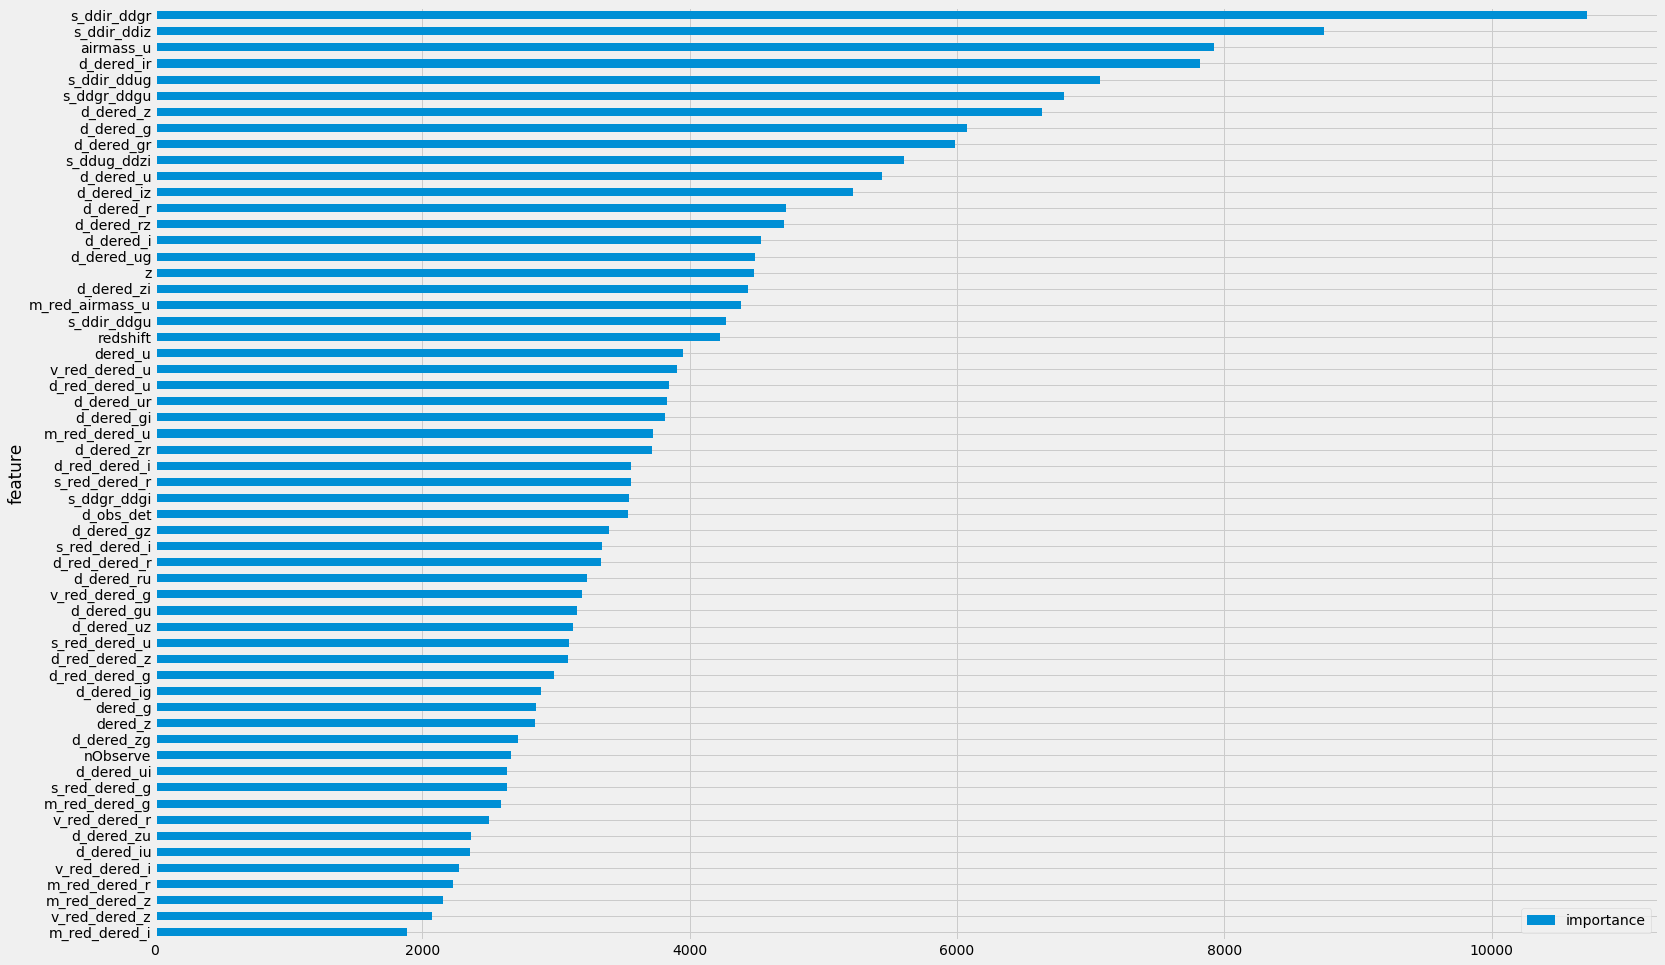

In [32]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

In [33]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [34]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [35]:
sub[target_col].value_counts()

2    40719
0    29985
1     9296
Name: class, dtype: int64

<h1>제출 파일 생성

In [45]:
sub.to_csv(sub_file)